In [3]:
import sys
sys.path.append("/home/ubuntu/fs/dsb17/code")

In [11]:
import dicom
from glob import glob
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

import matplotlib.pyplot as plt

from keras.models import Model

import lunaIterator; reload(lunaIterator)
from lunaIterator import lunaIterator, segment_lungs

import lunaModel; reload(lunaModel)
from lunaModel import get_unet

%matplotlib inline

In [5]:
data_path = '/home/ubuntu/fs/data/dsb17/'

luna_path = data_path+'luna16/'
weights_path = luna_path+'results/'

scan_path = data_path+'stage1/'
labels_file = data_path+'stage1_labels.csv'
test_file = data_path+'stage1_sample_submission.csv'
results_path = data_path+'results/'

## Steps

Find nodules
1. Load DICOM image
2. Preprocess same as luna16
3. Predict nodule from unet segmenter
4. Save nodule mask

Feature extract
1. Load all masks for patient
2. Extract hand designed features
3. Save feature vector with cancer id

## Segment dsb17

In [6]:
model = get_unet()
model.load_weights(weights_path+'weights_1e-5_04_-0.601.hdf5')

In [7]:
df = pd.read_csv(labels_file)
df.sort_values(by='id')
df.head()

id  cancer
0  0015ceb851d7251b8f399e39779d1e7d       1
1  0030a160d58723ff36d73f41b170ec21       0
2  003f41c78e6acfa92430a057ac0b306e       0
3  006b96310a37b36cccb2ab48d10b49a3       1
4  008464bb8521d09a42985dd8add3d0d2       1

In [8]:
uid = df.loc[0, 'id']
print uid

0015ceb851d7251b8f399e39779d1e7d


In [9]:
# get all files for uid
scans = glob(scan_path+uid+'/*.dcm')
print len(scans)

195


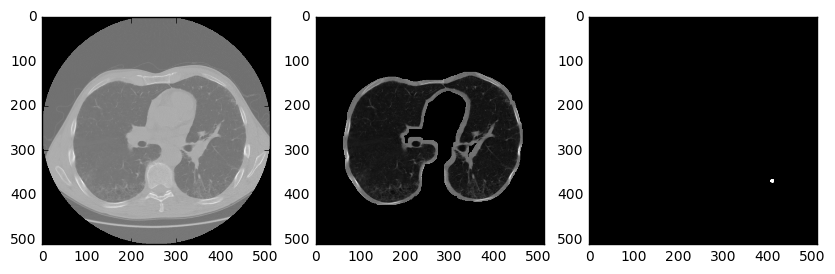

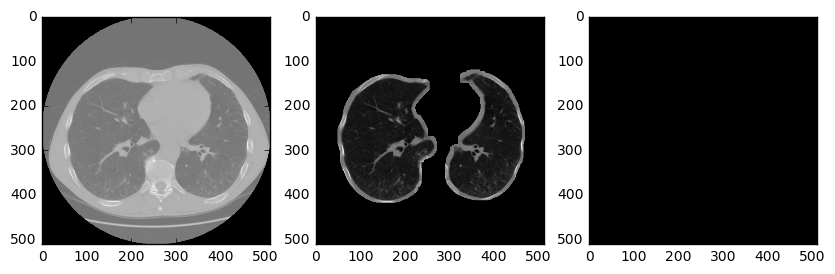

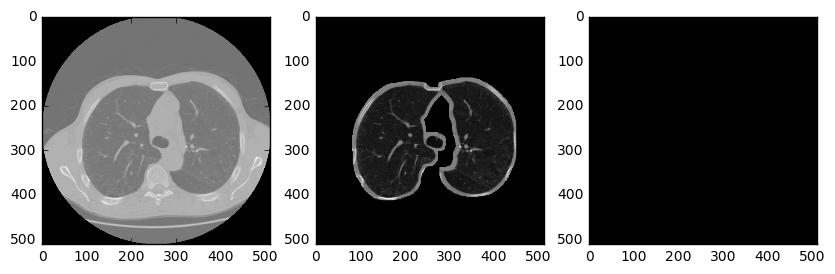

In [13]:
lungs = np.ndarray([1, 1, 512, 512])
for i in range(0,3):
    dcm = dicom.read_file(scans[i])
    img = dcm.pixel_array
    lungs[0, 0] = segment_lungs(img)
    nod = model.predict(lungs)
    
    fig, ax = plt.subplots(1,3,figsize=[10,10])
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].imshow(lungs[0,0], cmap=plt.cm.gray)
    ax[2].imshow(nod[0,0], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# import time
# from tqdm import tqdm
# start = time.time()

# lungs = np.ndarray([len(scans), 1, 512, 512])
# for i in tqdm(range(len(scans))):
#     dcm = dicom.read_file(scans[i])
#     img = dcm.pixel_array
    
#     lung = np.ndarray([1, 512, 512])
#     lung[0] = segment_lungs(img)
#     lungs[i] = lung
    
# end = time.time()
# print(end-start)

In [ ]:
# start = time.time()
# nod = model.predict(lungs, batch_size=2, verbose=1)
# end = time.time()
# print(end-start)

In [ ]:
# nod.shape

In [ ]:
# np.save(data_path+'segmented/'+uid+'.npy', nod.astype('uint8'))

That was too slow

## Generator

In [14]:
img_width = 512
img_height = 512

class dsbIterator(object):
    
    def __init__(self, files, batch_size=2, shuffle=False, seed=None):
        self.files = files
        self.n = len(files)
        self.batch_size = batch_size
        self.batch_index = 0
        self.total_batches_seen = 0
        self.index_generator = self._gen_index(self.n, batch_size, shuffle, seed)
        
    def reset(self):
        self.batch_index = 0
        
    def _gen_index(self, n , batch_size=32, shuffle=False, seed=None):
        
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)
                    
            current_index = (self.batch_index * batch_size) % n
            if n >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield(index_array[current_index: current_index + current_batch_size],
                     current_index, current_batch_size)
            
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        
        index_array, current_index, current_batch_size = next(self.index_generator)

        lungs = np.ndarray([current_batch_size, 1, img_width, img_height])
        for i in range(0, current_batch_size):
            
            # get image data and file
            dcm = dicom.read_file(self.files[i])
            img = dcm.pixel_array
            
            # segment lungs
            lungs[i, 0] = segment_lungs(img)
            
        return lungs

In [15]:
# start = time.time()

# uid = df.loc[0, 'id']
# scans = glob(scan_path+uid+'/*.dcm')
# dsb_gen = dsbIterator(scans)
# nod = model.predict_generator(dsb_gen, len(scans))
# print(nod.shape)
# np.save(data_path+'segmented/'+uid+'.npy', nod.astype('uint8'))

# end = time.time()
# print(end-start)

In [16]:
# df = pd.read_csv(labels_file)
# df.sort_values(by='id')
# model = get_unet()
# model.load_weights(weights_path+'weights_1e-5_04_-0.601.hdf5')

# for i in tqdm(range(10)):
#     uid = df.loc[i, 'id']
#     scans = glob(scan_path+uid+'/*.dcm')
#     dsb_gen = dsbIterator(scans)
#     nod = model.predict_generator(dsb_gen, len(scans))
#     np.save(data_path+'segmented/'+uid+'.npy', nod.astype('uint8'))

Move to script

## View output

In [42]:
scan_seg = np.load(data_path+'segmented/train/'+uid+'.npy')

In [43]:
scan_seg.shape

(195, 1, 512, 512)

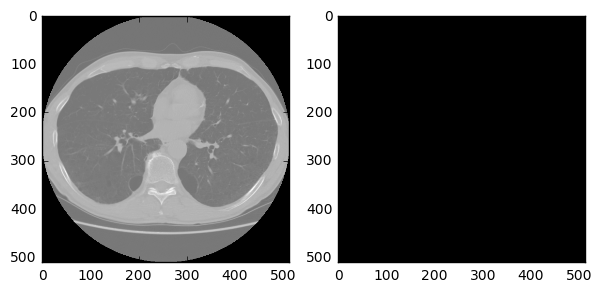

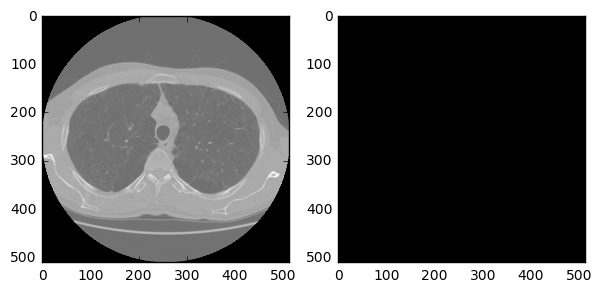

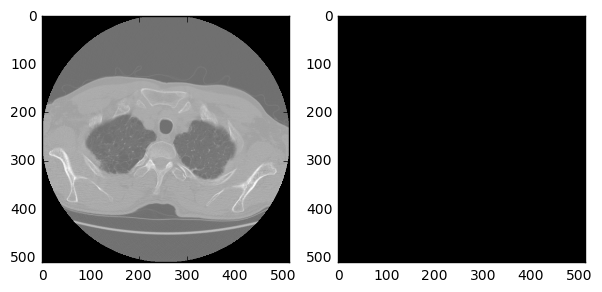

In [97]:
scans = glob(scan_path+uid+'/*.dcm')

for i in range(0,3):
    dcm = dicom.read_file(scans[i])
    img = dcm.pixel_array
    
    fig, ax = plt.subplots(1,2,figsize=[7,5])
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].imshow(scan_seg[i,0], cmap=plt.cm.gray)
    plt.show()

## Sort output by virtical location

Fixing issue where sorting was not done during segmentation done. In the future, this should be done before segmentation so the saved segmented file is in order by veritcal location.

In [45]:
slices = [dicom.read_file(scan) for scan in scans]

In [46]:
len(slices)

195

In [47]:
# create dataframe
instnums = np.ndarray(len(slices))
for i in range(0, len(slices)):
    instnums[i] = slices[i].InstanceNumber
    
df = pd.DataFrame(instnums, columns={'InstanceNumber'})
df.head()

InstanceNumber
0           106.0
1            89.0
2           131.0
3            56.0
4            38.0

In [48]:
df_sort = df.sort_values(by='InstanceNumber')
df_sort.head()

InstanceNumber
107             1.0
173             2.0
77              3.0
22              4.0
162             5.0

In [49]:
idx_list = df_sort.index
idx_list

Int64Index([107, 173,  77,  22, 162,  97, 139, 125, 154,  16,
            ...
             15, 104,  69, 147, 166,  29,  60, 111,  24,  58],
           dtype='int64', length=195)

In [50]:
scan_seg_sort = scan_seg[idx_list]

In [41]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate_z(img3d):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(img3d[0, 0, :, :], cmap=plt.cm.bone, animated=True);
    def update(i):
        im.set_array(img3d[i, 0, :, :])
        return im,
    
    ani = animation.FuncAnimation(fig, update, frames=img3d.shape[0], interval=50, blit=True)
    plt.close()
    
    return ani
   
anim = animate_z(scan_seg_sort);
HTML(anim.to_html5_video())

In [51]:
def sort_seg_vert(uid):
    # load segmented scans and original dcm files
    scan_seg = np.load(data_path+'segmented/train/'+uid+'.npy')
    scans = glob(scan_path+uid+'/*.dcm')
    slices = [dicom.read_file(scan) for scan in scans]
    
    # create dataframe from instance number
    instnums = np.ndarray(len(slices))
    for i in range(0, len(slices)):
        instnums[i] = slices[i].InstanceNumber

    # sort dataframe by instance number and get order to index segmented scans
    df = pd.DataFrame(instnums, columns={'InstanceNumber'})
    df_sort = df.sort_values(by='InstanceNumber')
    idx_list = df_sort.index
    
    # return segmented scans as 3D numpy array in order by instance number
    return scan_seg[idx_list]

In [55]:
# Go through each file in segmented training folder and order
# files = glob(data_path+'segmented/train/'+'*.npy')

# for f in tqdm(files):
#     base = os.path.basename(f)
#     uid = os.path.splitext(base)[0]
    
#     sort_seg = sort_seg_vert(uid)
#     np.save(data_path+'segmented/train/'+uid+'.npy', sort_seg.astype('uint8'))

100%|██████████| 1397/1397 [36:15<00:00,  1.45s/it]


## View new output

In [100]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

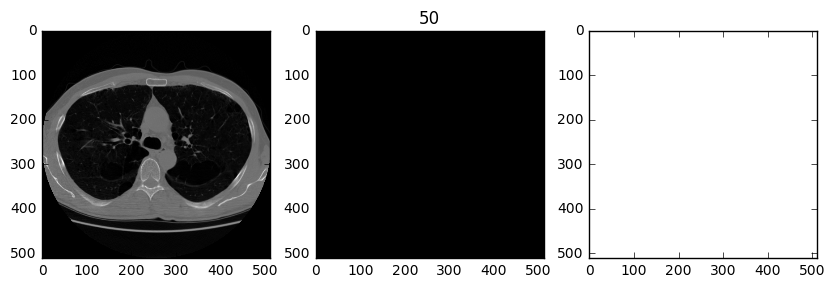

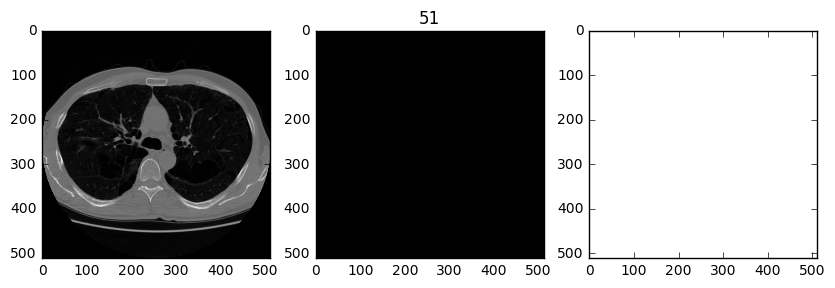

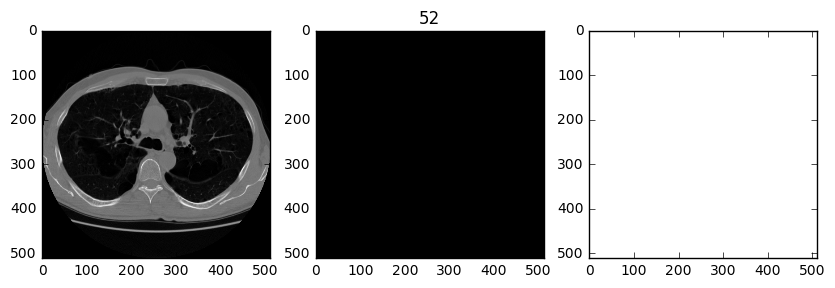

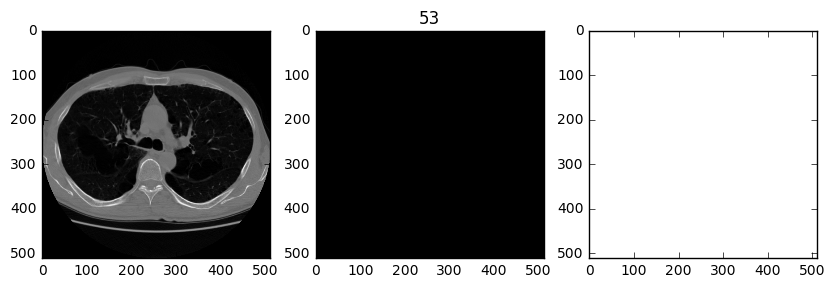

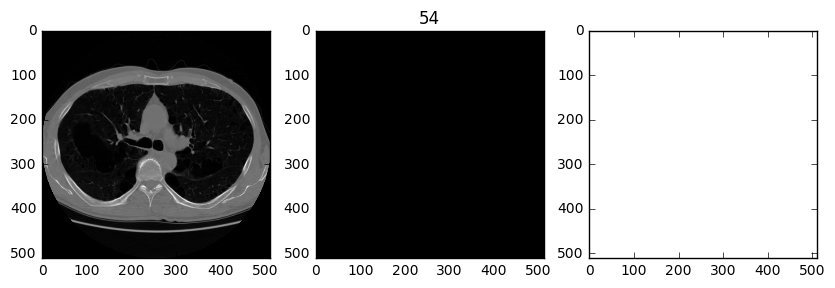

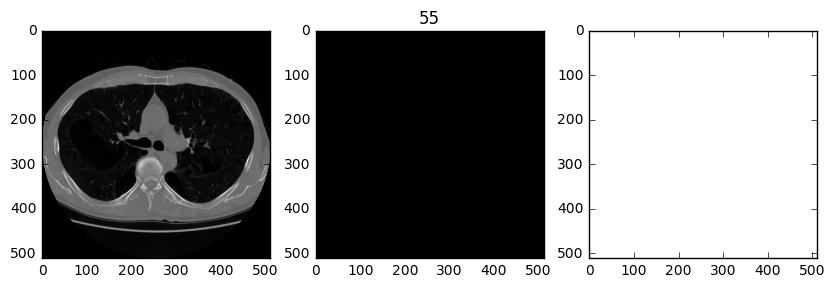

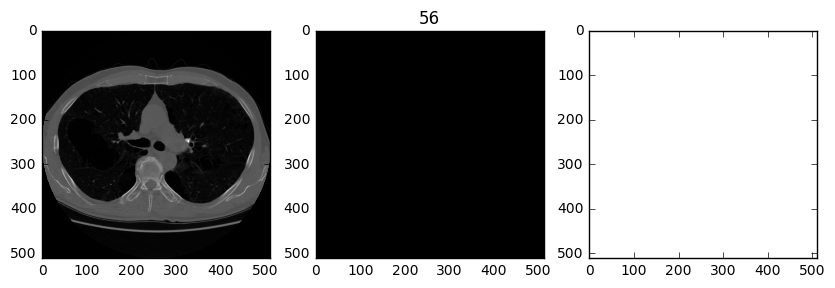

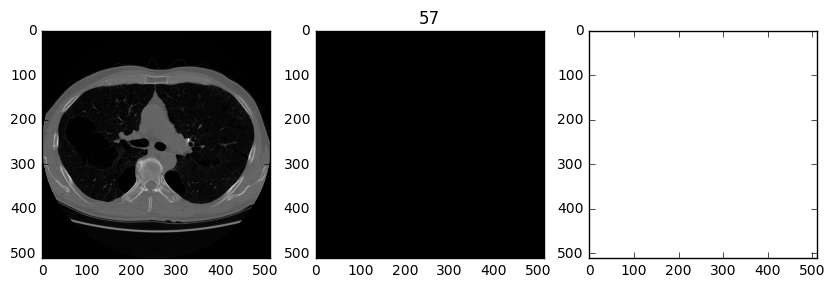

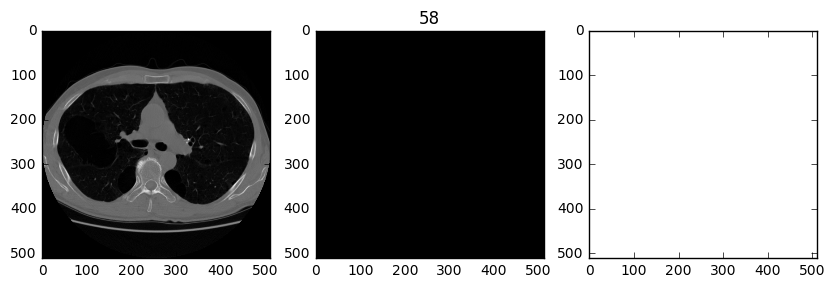

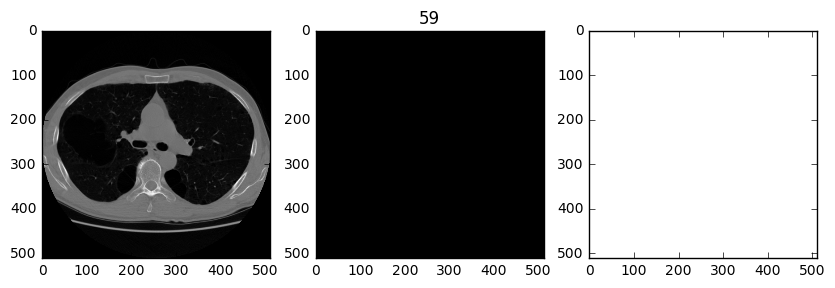

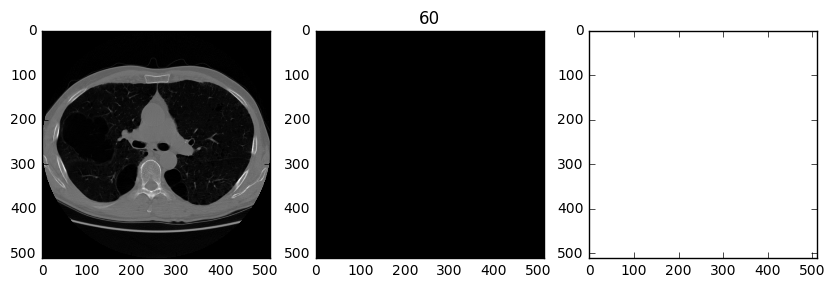

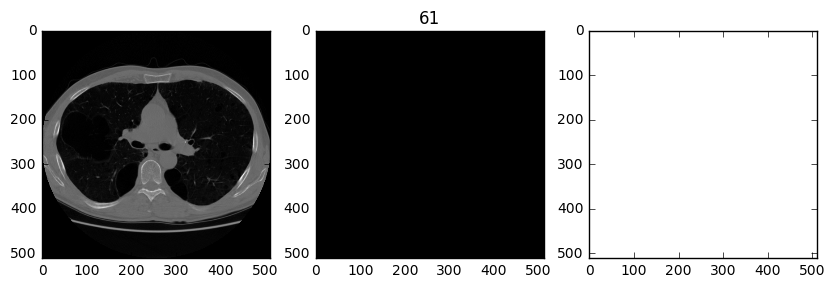

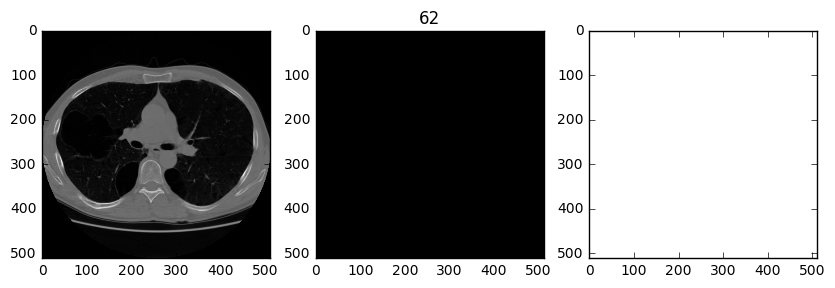

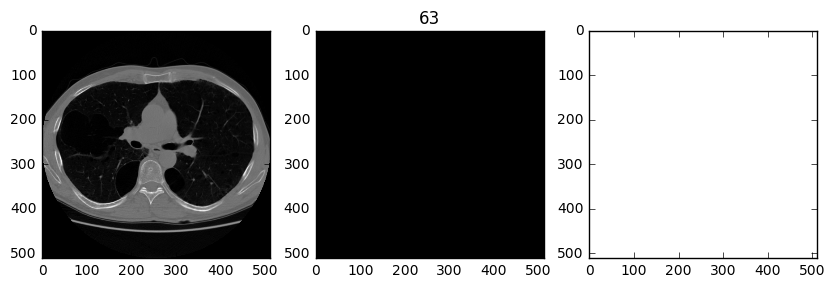

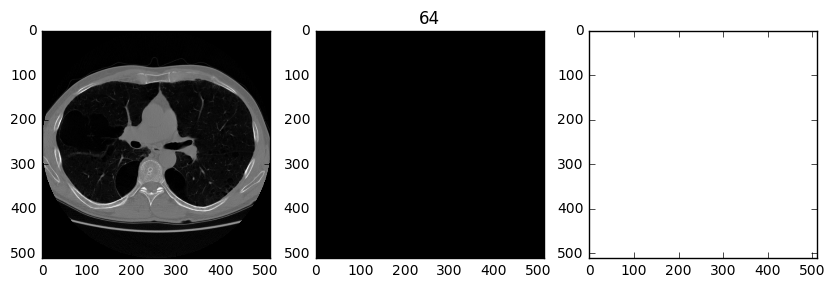

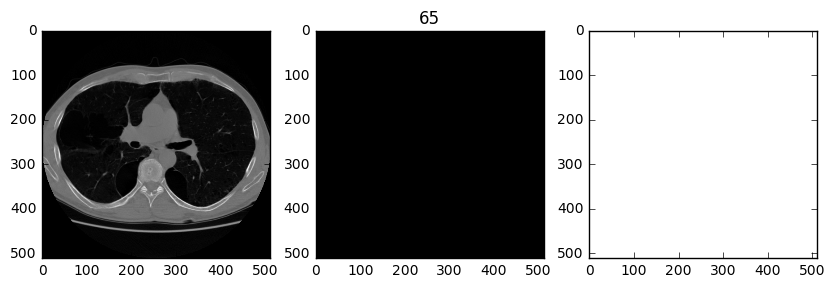

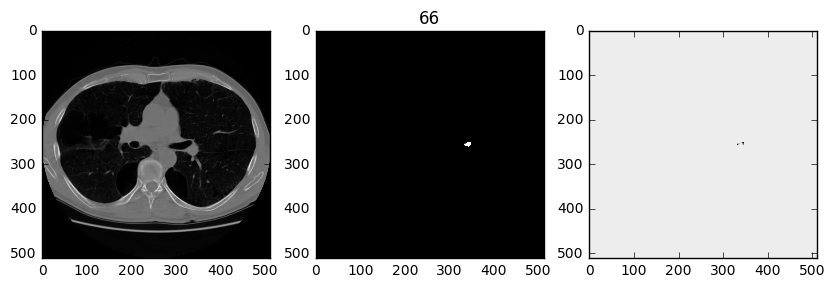

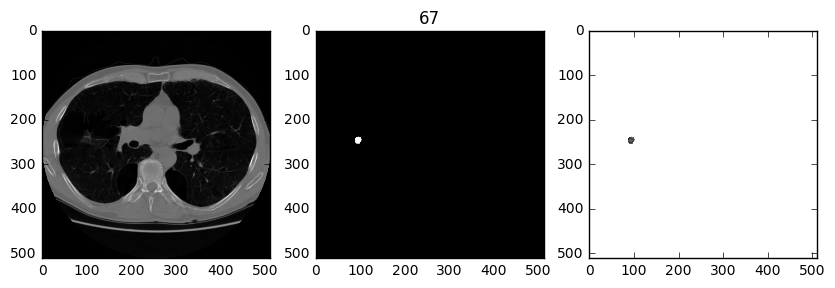

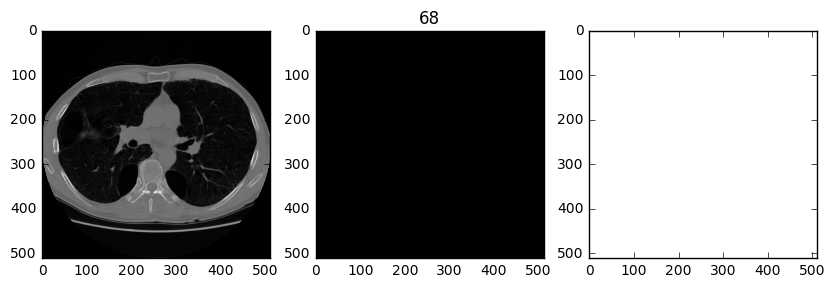

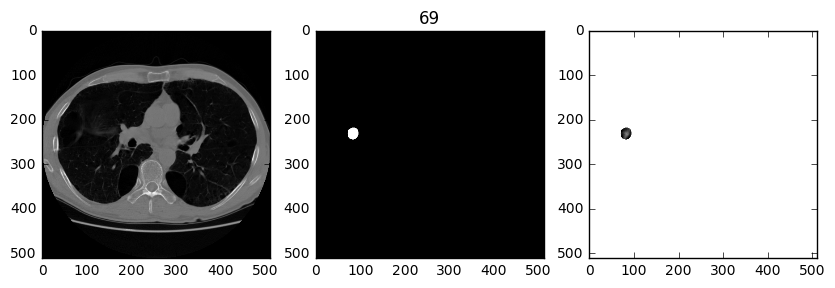

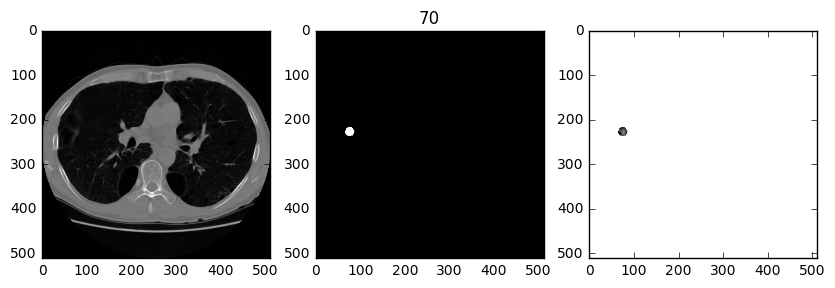

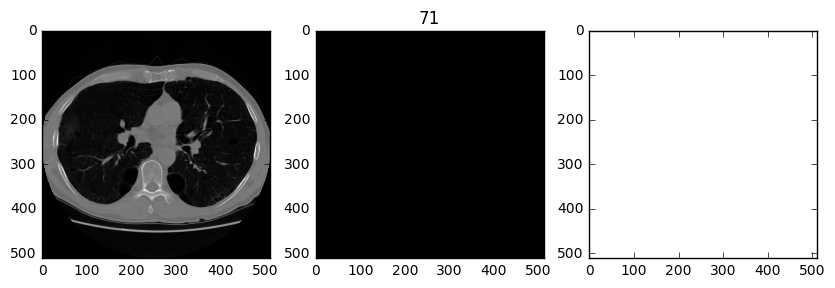

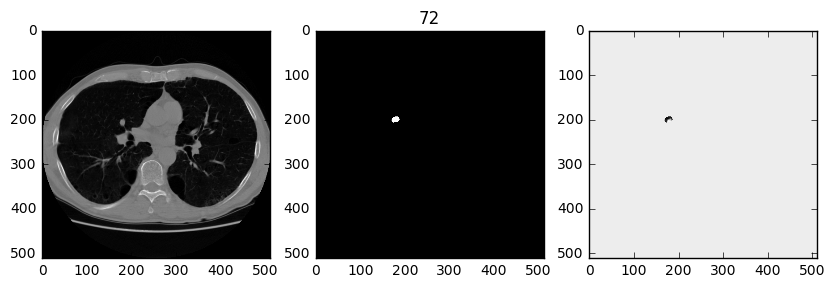

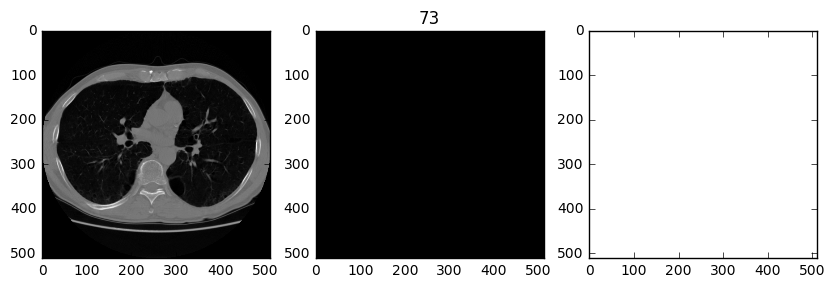

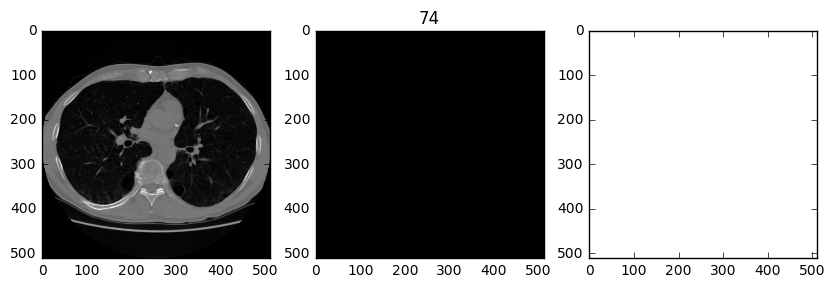

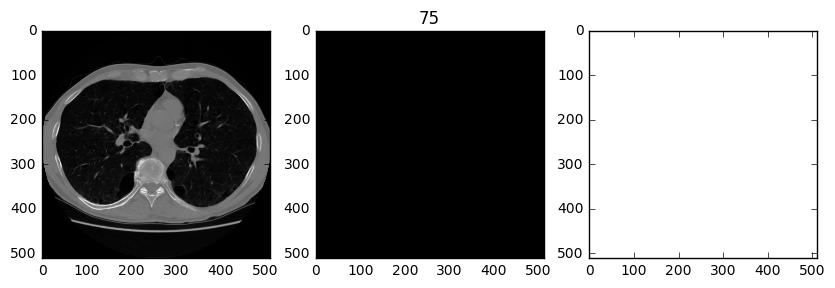

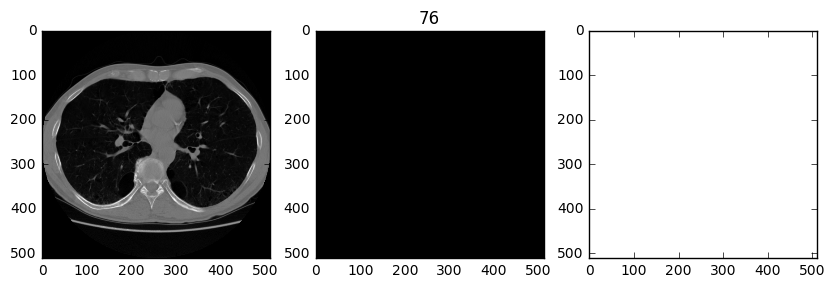

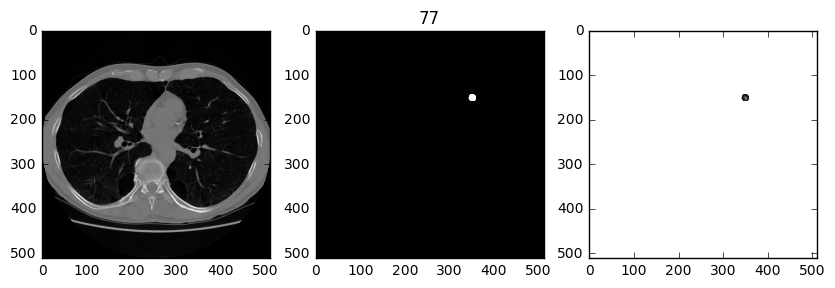

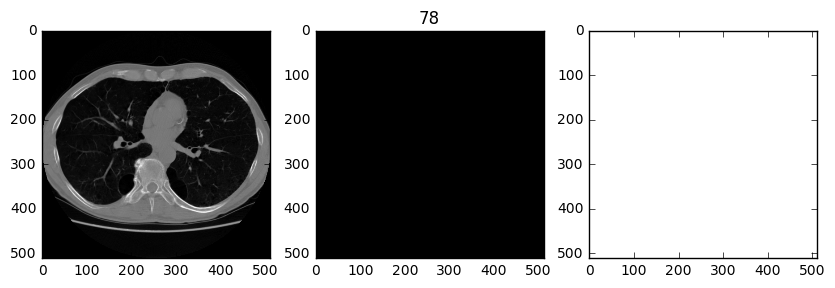

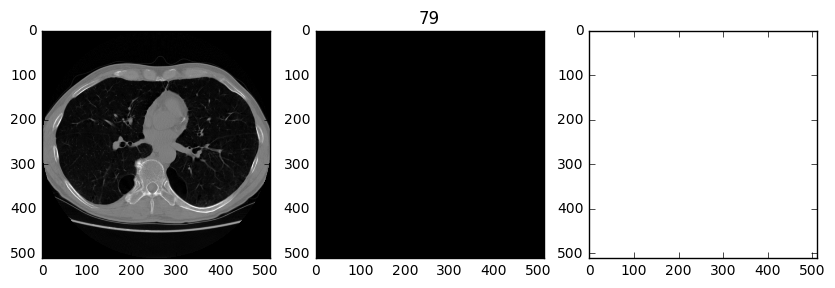

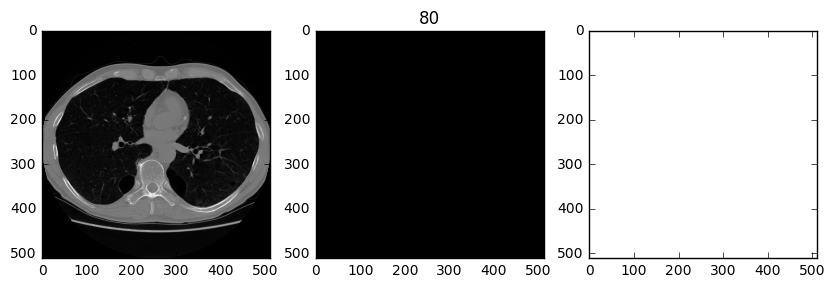

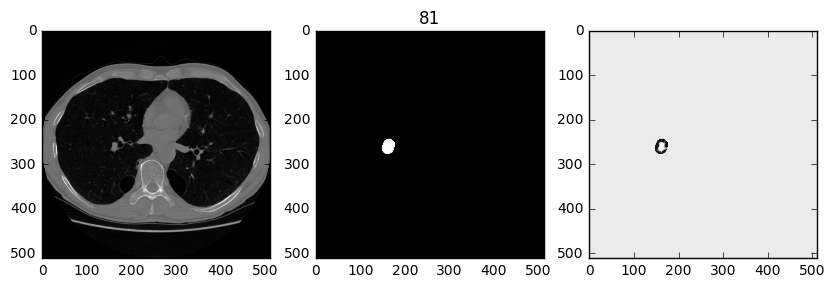

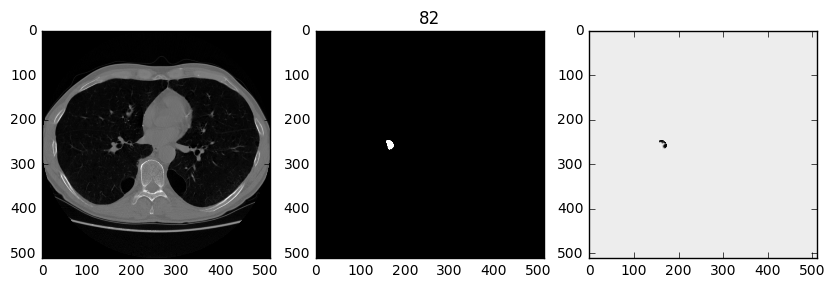

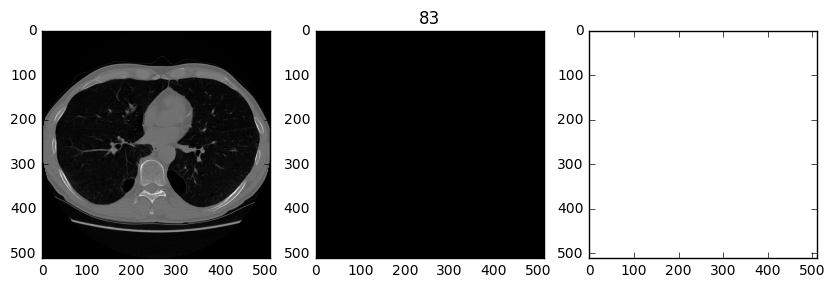

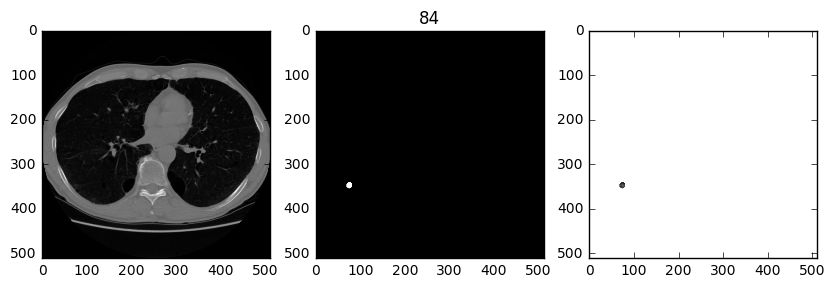

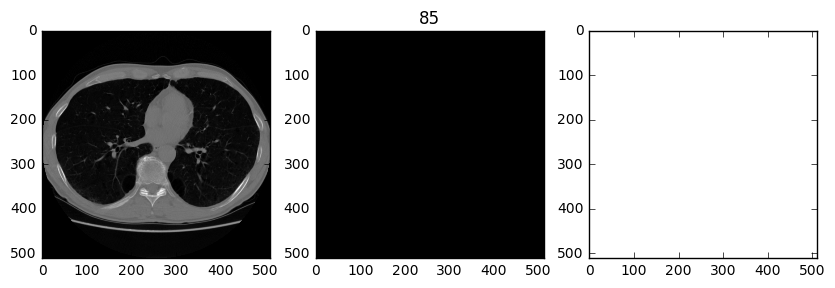

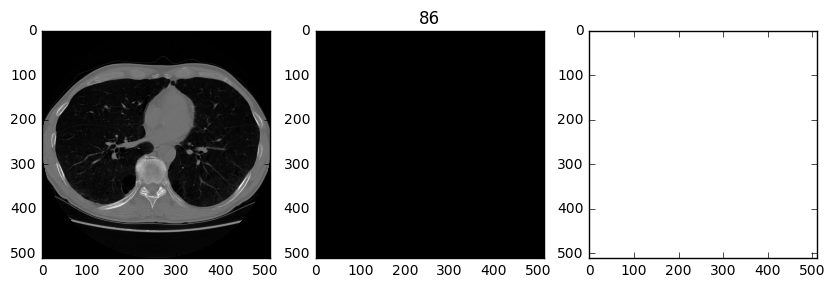

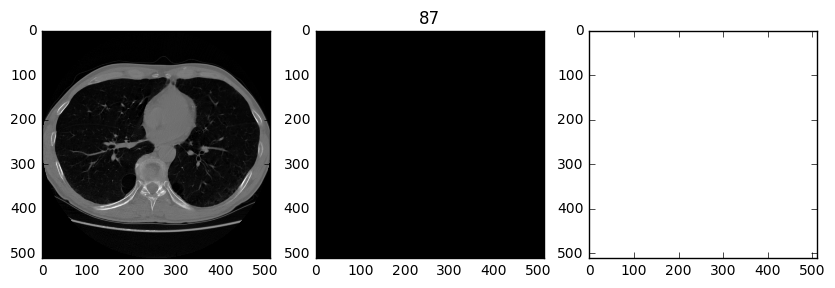

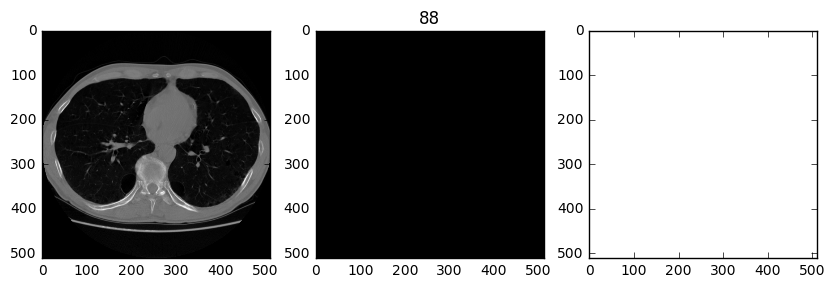

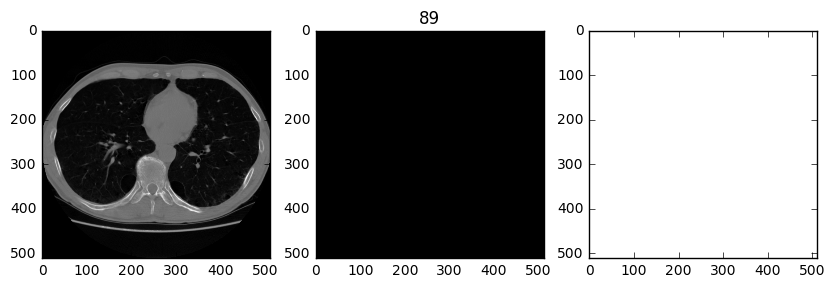

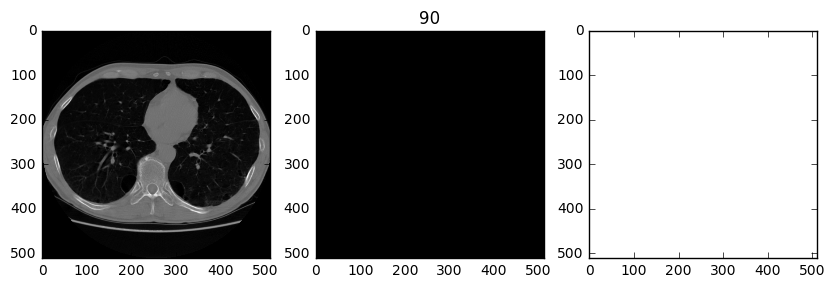

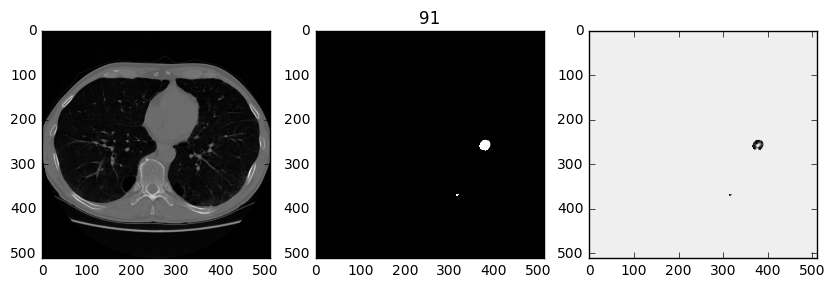

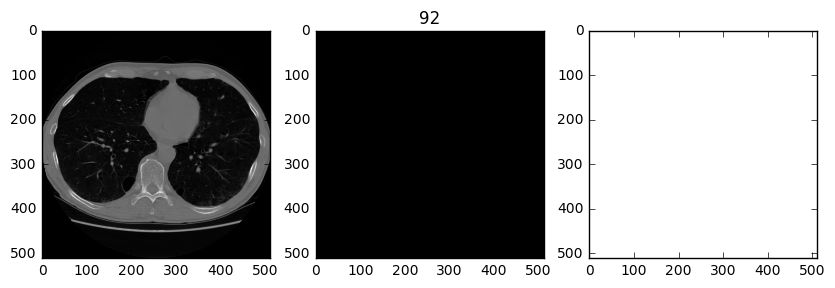

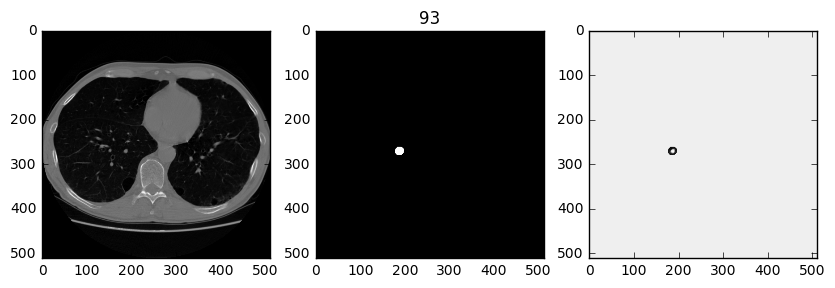

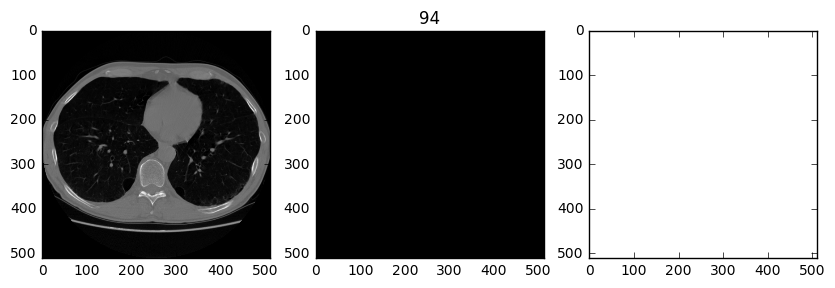

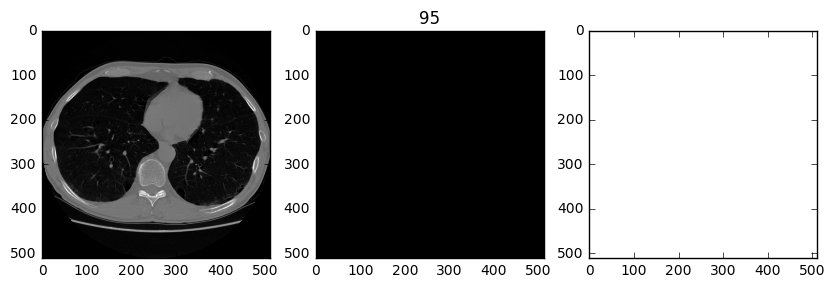

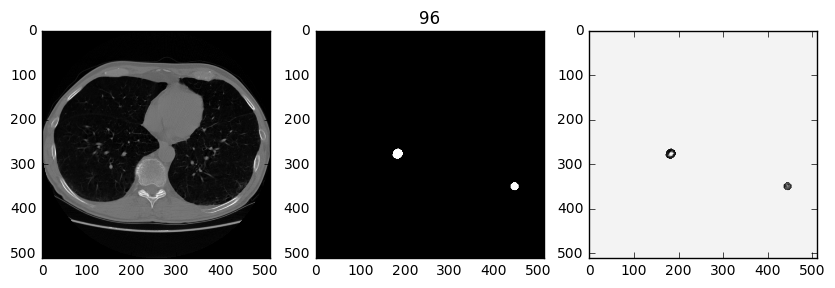

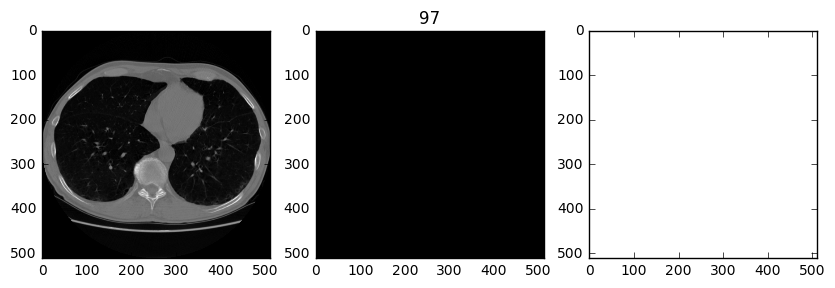

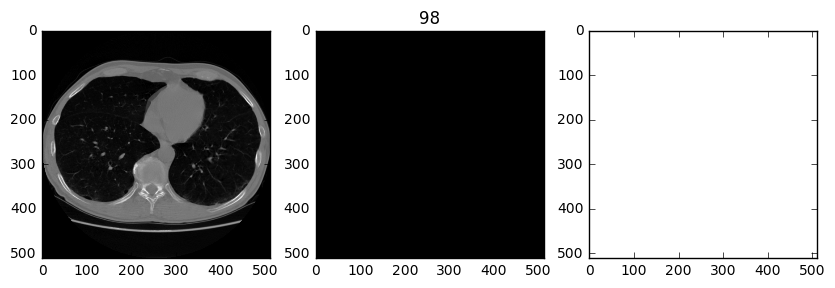

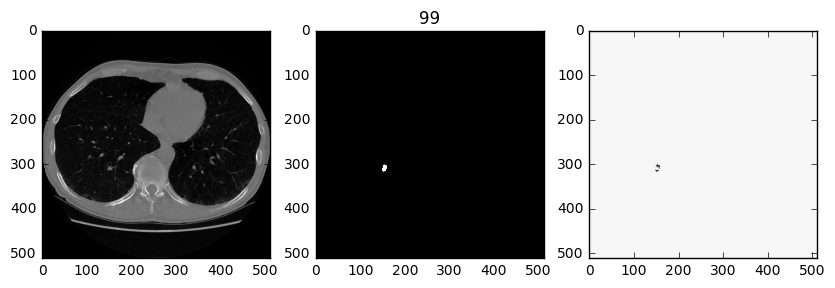

In [117]:
dcm_slices = [dicom.read_file(scan) for scan in scans]
dcm_slices.sort(key = lambda x: int(x.InstanceNumber))
scan_seg = np.load(data_path+'segmented/train/'+uid+'.npy')

dcm_images = get_pixels_hu(dcm_slices)

for i in range(50, 100):
    fig, ax = plt.subplots(1,3,figsize=[10,10])
    ax[0].imshow(dcm_images[i], cmap=plt.cm.gray)
    ax[1].imshow(scan_seg[i,0], cmap=plt.cm.gray)
    ax[1].set_title('{}'.format(i))
    ax[2].imshow(scan_seg[i,0]*dcm_images[i], cmap=plt.cm.gray)
    plt.show()

## Extract Features

### Code from tutorial

In [66]:
def getRegionFromMap(slice_npy):
    thr = np.where(slice_npy > np.mean(slice_npy),-1,1)
    label_image = measure.label(thr)
    labels = label_image.astype(int)
    regions = measure.regionprops(labels)
    return regions

def getRegionMetricRow(fname):
    # fname, numpy array of dimension [#slices, 1, 512, 512] containing the images
    seg = np.load(fname)
    nslices = seg.shape[0]
    
    #metrics
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512
    minAllowedArea = 16
    
    areas = []
    eqDiameters = []
    for slicen in range(nslices):
        regions = getRegionFromMap(seg[slicen,0,:,:])
        for region in regions:
            if region.area > maxAllowedArea or region.area < minAllowedArea:
                continue
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1
            
    weightedX = weightedX / totalArea 
    weightedY = weightedY / totalArea
    avgArea = totalArea / numNodes
    avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = np.avg(eqDiameters)
    stdEquivlentDiameter = np.std(eqDiameters)
    
    maxArea = max(areas)
    
    
    numNodesperSlice = numNodes*1. / nslices
    
    
    return np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                     stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice])

### More Custom Features

In [63]:
def load_scan(scan_path):
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
       
    return slices

In [73]:
def zloc_min_max(slices):
    zlocs = [s.ImagePositionPatient[2] for s in slices]
    return min(zlocs), max(zlocs)

Count number of nodules in each quadrant

In [81]:
maxAllowedArea = 0.10 * 512 * 512
minAllowedArea = 16

dcm_slices = load_scan(scan_path+uid)
seg_slices = np.load(data_path+'segmented/train/'+uid+'.npy')
nslices = seg_slices.shape[0]

dcm_slices = [dicom.read_file(scan) for scan in scans]
dcm_slices.sort(key = lambda x: int(x.InstanceNumber))

zlocs = []

for slicen in range(nslices):
    regions = getRegionFromMap(seg_slices[slicen,0,:,:])

    for region in regions:
        if region.area > maxAllowedArea or region.area < minAllowedArea:
            continue
            
        zlocs.append(dcm_slices[slicen].ImagePositionPatient[2])

z_min, z_max = zloc_min_max(dcm_slices)
quad_len = (z_max-z_min)/4
q1 = z_min + quad_len
q2 = z_min + 2*quad_len
q3 = z_min + 3*quad_len

q0_cnt = 0
q1_cnt = 0
q2_cnt = 0
q3_cnt = 0

for loc in zlocs:
    if loc <= q1: 
        q0_cnt += 1
    elif loc <= q2:
        q1_cnt += 1
    elif loc <= q2:
        q2_cnt += 1
    else:
        q3_cnt += 1

In [103]:
print(zlocs)

['-356.109985', '-354.109985', '-354.109985', '-348.109985', '-336.109985', '-332.109985', '-330.109985', '-304.109985', '-304.109985', '-298.109985', '-252.110001', '-250.110001', '-246.110001', '-244.110001', '-240.110001', '-230.110001', '-222.110001', '-220.110001', '-216.110001', '-202.110001', '-202.110001', '-198.110001', '-192.110001', '-192.110001', '-186.110001', '-170.110001', '-166.110001', '-162.110001', '-160.110001', '-160.110001', '-158.110001', '-144.110001', '-122.110001', '-120.110001', '-114.110001', '-110.110001']


In [83]:
print(q0, q1, q2)
print(len(zlocs), q0_cnt, q1_cnt, q2_cnt, q3_cnt)

(-287.10998875, -287.10998875, -190.1099925)
(36, 10, 14, 0, 12)


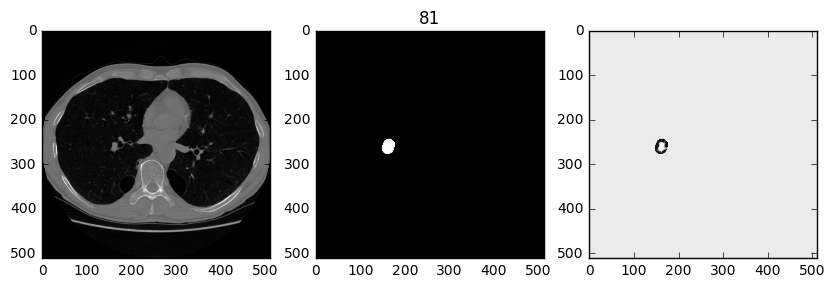

In [153]:
# nodule type, how solid
# measure maxinum HU and average HU for pixel in dcm scan
dcm_images = get_pixels_hu(dcm_slices)

fig, ax = plt.subplots(1,3,figsize=[10,10])
ax[0].imshow(dcm_images[81], cmap=plt.cm.gray)
ax[1].imshow(scan_seg[81,0], cmap=plt.cm.gray)
ax[1].set_title('{}'.format(81))
ax[2].imshow(scan_seg[81,0]*dcm_images[81], cmap=plt.cm.gray)
plt.show()

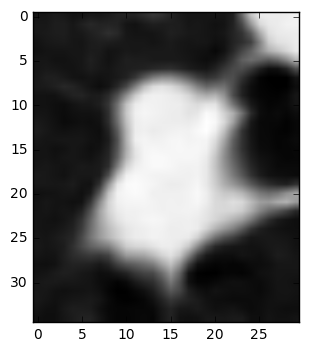

(96, -648.66095238095238, 388.88771460477068)


In [156]:
img = scan_seg[81,0]

label_image = measure.label(img)
labels = label_image.astype(int)
regions = measure.regionprops(labels)

for region in regions:
    if region.area > maxAllowedArea or region.area < minAllowedArea:
        continue
        
    seg = dcm_images[81]
    min_x, min_y, max_x, max_y = region.bbox
    seg = seg[min_x:max_x, min_y:max_y]
    
    max_hu = seg.max()
    avg_hu = np.average(seg)
    std_hu = np.std(seg)
        
    plt.imshow(seg, cmap=plt.cm.gray)
    plt.show()
    
    print(max_hu, avg_hu, std_hu)

In [163]:
def get_regions(seg_slice):
    thr = np.where(seg_slice > np.mean(seg_slice),-1,1)
    label_image = measure.label(thr)
    labels = label_image.astype(int)
    regions = measure.regionprops(labels)
    return regions

def get_features(seg_path):

    uid = os.path.basename(seg_path)
    uid = os.path.splitext(uid)[0]
    
    dcm_slices = load_scan(scan_path+uid)
    seg_slices = np.load(data_path+'segmented/train/'+uid+'.npy')
    nslices = seg_slices.shape[0]

    dcm_slices = [dicom.read_file(scan) for scan in scans]
    dcm_slices.sort(key = lambda x: int(x.InstanceNumber))
    dcm_images = get_pixels_hu(dcm_slices)
    
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512
    minAllowedArea = 16
    
    #metrics
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
       
    areas = []
    eqDiameters = []
    zlocs = []
    max_hu = []
    avg_hu = []
    
    z_min, z_max = zloc_min_max(dcm_slices)
    quad_len = (z_max-z_min)/4
    q1 = z_min + quad_len
    q2 = z_min + 2*quad_len
    q3 = z_min + 3*quad_len

    q0_cnt = 0
    q1_cnt = 0
    q2_cnt = 0
    q3_cnt = 0
    
    
    for slicen in range(nslices):
        regions = get_regions(seg_slices[slicen,0,:,:])
        for region in regions:
            if region.area > maxAllowedArea or region.area < minAllowedArea:
                continue
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1
            
            zlocs.append(dcm_slices[slicen].ImagePositionPatient[2])
            
            seg = dcm_images[slicen]
            min_x, min_y, max_x, max_y = region.bbox
            seg = seg[min_x:max_x, min_y:max_y]

            max_hu.append(np.amax(seg))
            avg_hu.append(np.average(seg))
            
    weightedX = weightedX / totalArea 
    weightedY = weightedY / totalArea
    avgArea = totalArea / numNodes
    avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = np.average(eqDiameters)
    stdEquivlentDiameter = np.std(eqDiameters)
    maxArea = max(areas)
    numNodesperSlice = numNodes*1. / nslices
    
    # softest nodule found by absolute
    min_max_hu = min(max_hu)
    avg_max_hu = np.average(max_hu)
    
    # softest average
    min_avg_hu = min(avg_hu)
    
    # total average
    avg_avg_hu = np.average(avg_hu)
    
    for loc in zlocs:
        if loc <= q1: 
            q0_cnt += 1
        elif loc <= q2:
            q1_cnt += 1
        elif loc <= q2:
            q2_cnt += 1
        else:
            q3_cnt += 1
    
    
    return np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                     stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice, \
                     q0_cnt, q1_cnt, q2_cnt, q3_cnt, min_max_hu, avg_max_hu, min_avg_hu, avg_avg_hu])

In [165]:
feats = get_features(data_path+'segmented/train/'+uid+'.npy')
print(feats)

[  2.79138889e+02   7.87000000e+02   4.23480925e-01   1.80916172e+01
   5.30132610e+00   2.48528510e+02   2.76732411e+02   3.60000000e+01
   2.60869565e-01   1.10000000e+01   1.30000000e+01   0.00000000e+00
   1.20000000e+01  -6.54000000e+02  -1.38333333e+01  -8.69514706e+02
  -6.71760631e+02]


In [166]:
# spiculation
# http://ieeexplore.ieee.org/document/7281048/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2857703/

In [61]:
# emphysema
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.657.7533&rep=rep1&type=pdf